
**<h1 style="margin-left:30%;">Emotion Recognition from Speech</h1>**

<img src="https://miro.medium.com/v2/resize:fit:942/1*ILD0O04u2ofXrqC8h34oOg.png" alt="image" width="1300" height="auto">



## Import usefull libraries.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
from keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras.backend as k
from matplotlib import pyplot
import warnings
import seaborn as sns
warnings.filterwarnings ('ignore')

2024-06-18 15:58:34.713394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:58:34.713525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:58:34.850221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Importing & Storing.

Import the data from [TESS](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess) on kaggle.

In [2]:
all_wav = []
all_label = []

In [3]:
#Extract the label name from the wav name
#Append the path of the voice with the label of it
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_wav.append(os.path.join(dirname, filename))
        all_label.append((filename.split('_')[-1].split('.')[0]).lower())
print(all_wav[0])
print(all_label[0])

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
fear


In [4]:
#Create DataFrame and put the data in it to be easier to access and releate between the data
df = pd.DataFrame()
df['Wav'] = all_wav
df['Label'] = all_label
df.head()

,Wav,Label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [5]:
#Extract the classes
Labels = df['Label'].unique()
Labels

array(['fear', 'angry', 'disgust', 'neutral', 'sad', 'ps', 'happy'],
      dtype=object)

## Data Preprocessing.

1. Load the data using **librosa**.
1. Feature Extraction using Mel spectrograms, which are well-suited for capturing audio features.
1. normalize the spectrograms using Z-score normalization.
1. Padding is handled to ensure consistent input shapes.


In [6]:
def z_score_normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

In [7]:
all_wave = []
all_label = []

In [8]:
for label in Labels:
    waves = [f for f in df['Wav'] if f.split('_')[-1].split('.')[0].lower()==label ]
    for wav in waves:
        array, sample_rate = librosa.load(wav,duration=2,offset=0.5)
        spect = librosa.feature.melspectrogram(y=array, sr=sample_rate)
        log_spect = librosa.power_to_db(spect, ref=np.max)
        normalized_spect = z_score_normalize(log_spect)
        if normalized_spect.shape[1]<87:
            padded_spect = np.pad(normalized_spect, ((0, 0), (0, 87 - normalized_spect.shape[1])), mode='constant')
        all_wave.append(padded_spect)
        all_label.append(label)

In [9]:
# Replace With new values
df['Wav'] = all_wave
df['Label'] = all_label
df.head()

,Wav,Label
0,"[[1.581024, 1.9554887, 1.8089479, 1.3953493, 0...",fear
1,"[[0.47383642, 0.5143044, 1.1568718, 1.5002575,...",fear
2,"[[0.61552465, 0.76756084, 0.70798117, 0.496277...",fear
3,"[[0.92969215, 0.4644548, 0.4594771, 0.7386553,...",fear
4,"[[0.91467077, 1.1728826, 1.5311853, 1.449556, ...",fear


## Exploratory Data Analysis (EDA).

<Axes: xlabel='Label', ylabel='count'>

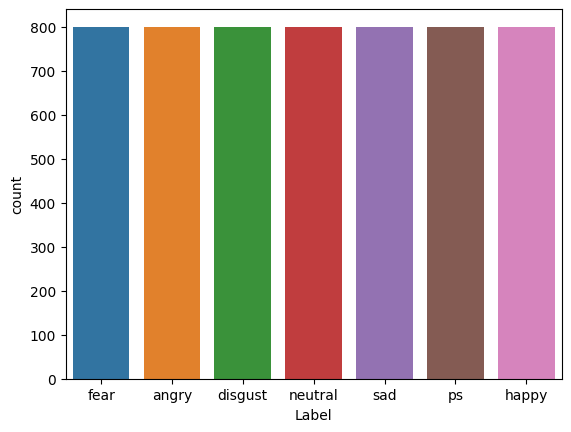

In [10]:
#Check if there is Unbalanced Classes
sns.countplot(df,x='Label')

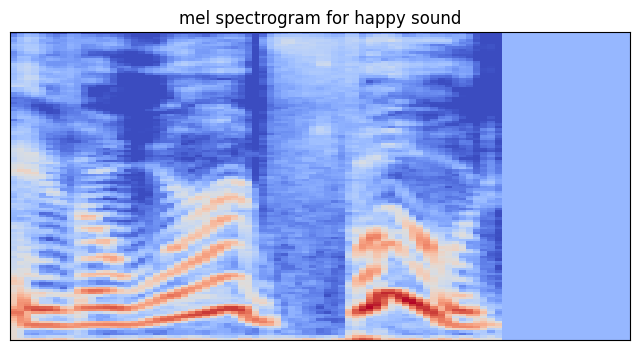

In [11]:
#View some spectrograms to undersand the pattern 
plt.figure(figsize=(8,4))
plt.title('mel spectrogram for ' + df['Label'][5500] +' sound')
librosa.display.specshow(df['Wav'][5500])
plt.show()

In [12]:
df['Wav'][0].shape

(128, 87)

## Label Encoding & One-hot encoding.

In [13]:
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [14]:
y = to_categorical(y, num_classes=len(classes))
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
#Data Shuffeling and Spliting
x_train, x_test, y_train, y_test = train_test_split(np.array(all_wave), np.array(y), test_size=0.2,shuffle=True,random_state=777,stratify=y)

## Model Design.

In [16]:
#Creating Input layer
inputs = layers.Input(shape=(128,87))
inputs

<KerasTensor shape=(None, 128, 87), dtype=float32, sparse=None, name=keras_tensor>

In [17]:
#Creating 1D Convolutional Layer 
conv = Conv1D(8,13,padding='valid',activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

In [18]:
#Creating Flatten layer
conv = Flatten()(conv)
#Creating 2 Dense Layers
conv = Dense(256,activation='relu')(conv)
conv = Dropout(0.3)(conv)
conv = Dense(128,activation='relu')(conv)
conv = Dropout(0.3)(conv)
#Creating Output Layer
outputs = Dense(len(Labels),activation='softmax')(conv)

In [19]:
model = models.Model(inputs,outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 87)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 116, 8)         │         9,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 304)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        78,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,935 (472.40 KB)

 Trainable params: 120,935 (472.40 KB)

 Non-trainable params: 0 (0.00 B)

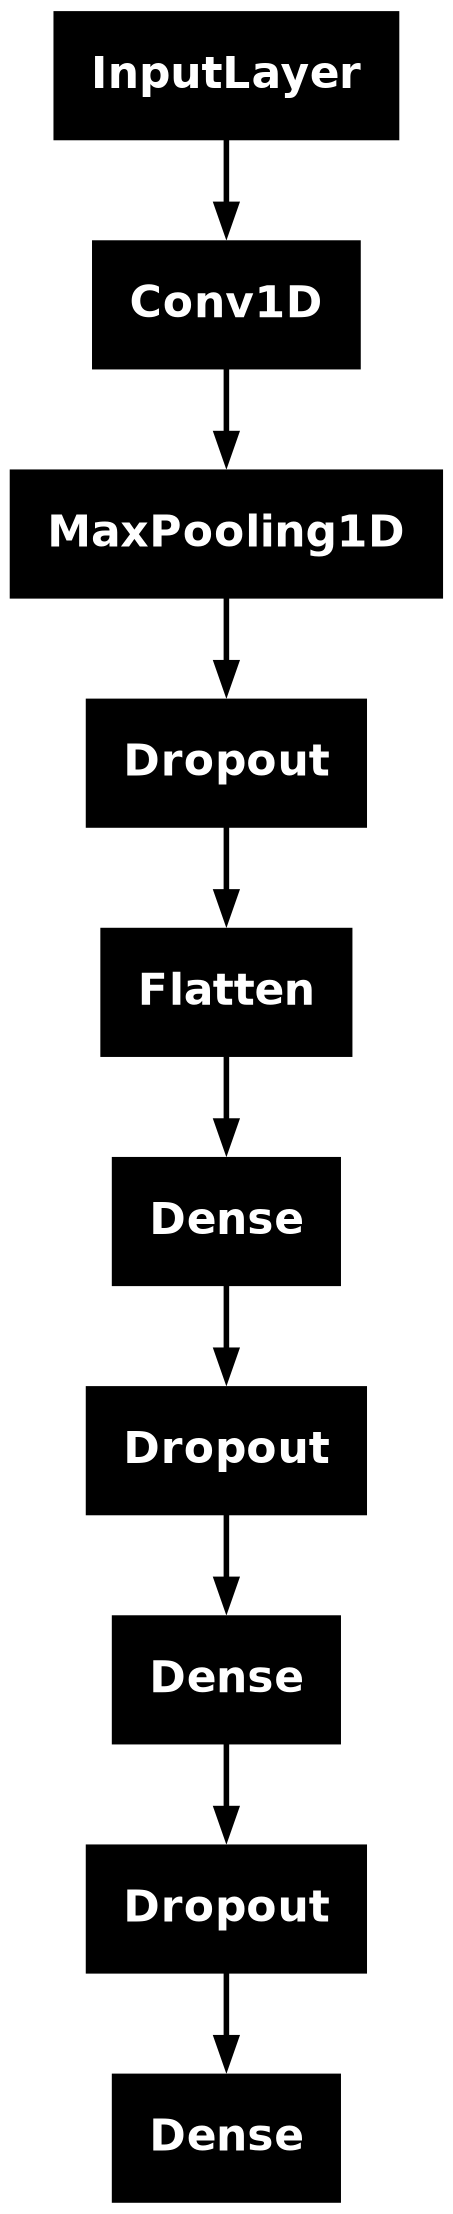

In [20]:
plot_model(model)

## Trainig

In [21]:
#Compile the model with categorical_crossentropy Loss function and adam Optimizer
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
#Early stopping & callbacks setup
es = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,restore_best_weights=True, min_delta=0.0001)
mc = callbacks.ModelCheckpoint('best_model.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
#Train the model with batch size 32 and 100 epochs and save the training data in history
history = model.fit(x_train,y_train,epochs=100,callbacks=[es,mc],validation_data=(x_test,y_test),batch_size=32)

Epoch 1/100
 62/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3381 - loss: 1.7990

I0000 00:00:1718726500.926072      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4779 - loss: 1.4290
Epoch 1: val_accuracy improved from -inf to 0.95714, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4989 - loss: 1.3734 - val_accuracy: 0.9571 - val_loss: 0.1494
Epoch 2/100
129/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9177 - loss: 0.2361
Epoch 2: val_accuracy improved from 0.95714 to 0.98214, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9186 - loss: 0.2338 - val_accuracy: 0.9821 - val_loss: 0.0604
Epoch 3/100
134/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.1264
Epoch 3: val_accuracy did not improve from 0.98214
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9581 - loss: 0.1257 - val_accuracy: 0.9821 - val_loss: 0.0580
Epoch 4/100
134/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9662 - loss: 0.1125
Epoch 4: val_accuracy improved from 0.98214 to 0.99107, saving model to best_model.kera

## Evaluation

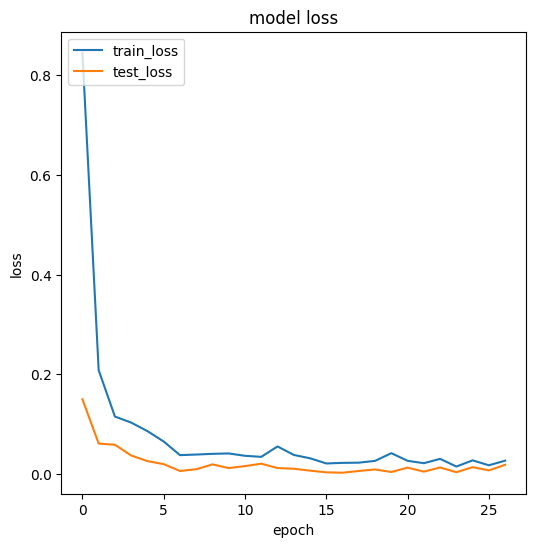

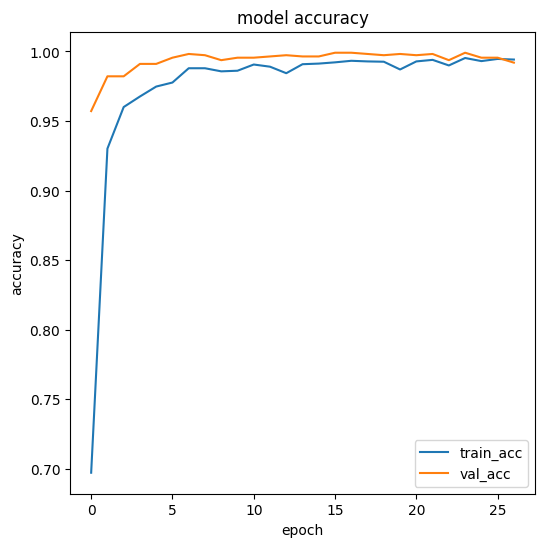

In [23]:
#Plotting Accuracy and Loss
pyplot.subplots(figsize=(6,6))
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train_loss', 'test_loss'], loc='upper left')
pyplot.show()

pyplot.subplots(figsize=(6,6))
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('model accuracy')
pyplot.legend(['train_acc','val_acc'])
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.show()

